In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

print("Библиотеки успешно импортированы")

Библиотеки успешно импортированы


Размер изображения: (400, 600)
Диапазон значений: от 0 до 255


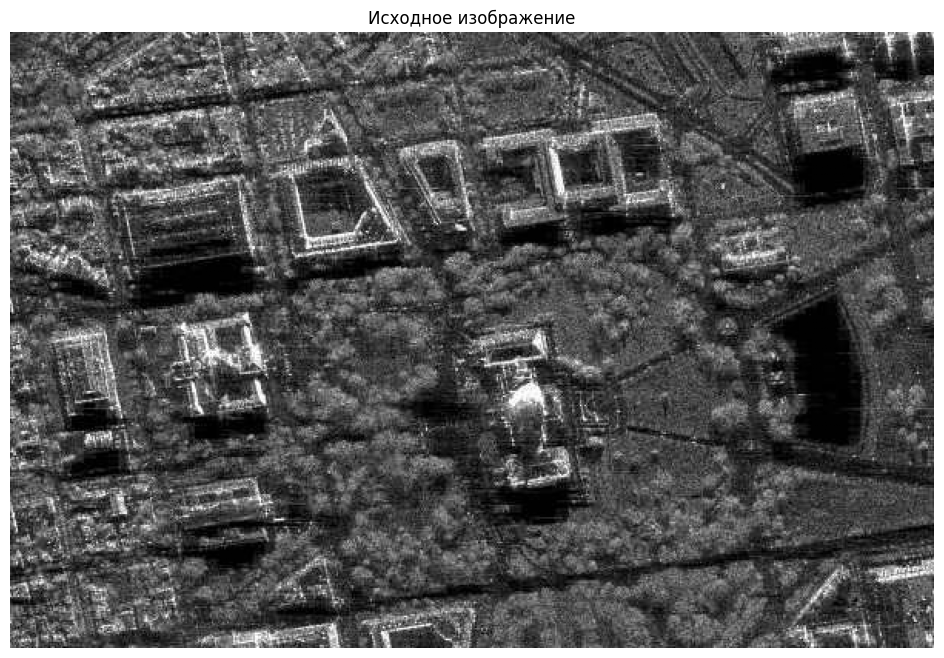

In [2]:
image_path = 'image/sar_1_gray.jpg'
original = cv2.imread(image_path)

# Преобразуем в оттенки серого если нужно
if len(original.shape) == 3:
    img_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
else:
    img_gray = original.copy()

print(f"Размер изображения: {img_gray.shape}")
print(f"Диапазон значений: от {img_gray.min()} до {img_gray.max()}")

# Показываем оригинал
plt.figure()
plt.imshow(img_gray)
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

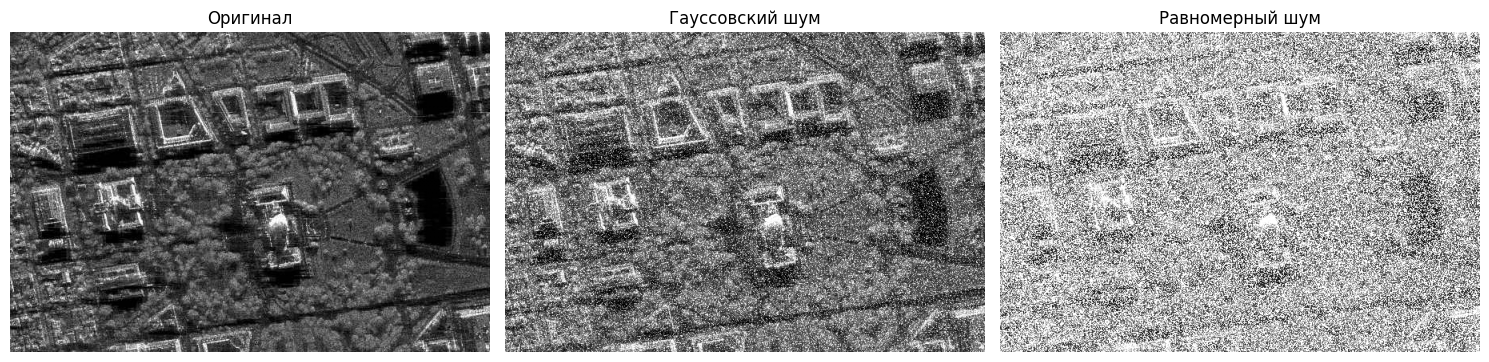

In [3]:
mean_val = 0
std_val = 100
noise_gaussian = np.zeros(img_gray.shape, np.uint8)
cv2.randn(noise_gaussian, mean_val, std_val)
img_with_gaussian = cv2.add(img_gray, noise_gaussian)

# Равномерный шум
low, high = -50, 50
noise_uniform = np.random.uniform(low, high, img_gray.shape).astype(np.uint8)
img_with_uniform = np.clip(img_gray.astype(np.int16) + noise_uniform, 0, 255).astype(np.uint8)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_gray)
axes[0].set_title('Оригинал')
axes[0].axis('off')

axes[1].imshow(img_with_gaussian)
axes[1].set_title('Гауссовский шум')
axes[1].axis('off')

axes[2].imshow(img_with_uniform)
axes[2].set_title('Равномерный шум')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [4]:
def compare_filters(noisy_img, clean_img):
    """Сравнение различных фильтров по MSE и SSIM"""

    # Создаем набор фильтров
    filtered_images = {
        # Гауссовские
        'Гаусс 3x3 σ=0': cv2.GaussianBlur(noisy_img, (3, 3), 0),
        'Гаусс 5x5 σ=0': cv2.GaussianBlur(noisy_img, (5, 5), 0),
        'Гаусс 3x3 σ=1': cv2.GaussianBlur(noisy_img, (3, 3), 1),
        'Гаусс 5x5 σ=1': cv2.GaussianBlur(noisy_img, (5, 5), 1),
        'Гаусс 3x3 σ=2': cv2.GaussianBlur(noisy_img, (3, 3), 2),
        'Гаусс 5x5 σ=2': cv2.GaussianBlur(noisy_img, (5, 5), 2),

        # Медианные
        'Медиана 3x3': cv2.medianBlur(noisy_img, 3),
        'Медиана 5x5': cv2.medianBlur(noisy_img, 5),

        # Билатеральные
        'Билатеральный σ=25': cv2.bilateralFilter(noisy_img, 9, 25, 25),
        'Билатеральный σ=75': cv2.bilateralFilter(noisy_img, 9, 75, 75),

        # NLM
        'NLM h=10': cv2.fastNlMeansDenoising(noisy_img, h=10),
        'NLM h=20': cv2.fastNlMeansDenoising(noisy_img, h=20)
    }

    results = {}
    print("Оценка качества фильтрации:")
    print("-" * 50)

    for name, filtered in filtered_images.items():
        mse_val = mean_squared_error(clean_img, filtered)
        ssim_val = structural_similarity(clean_img, filtered)

        results[name] = {
            'image': filtered,
            'mse': mse_val,
            'ssim': ssim_val
        }

        print(f"{name:25} MSE: {mse_val:7.1f} | SSIM: {ssim_val:.4f}")

    return results

In [5]:
print("Тестирование фильтров на изображении с гауссовским шумом:")
print("=" * 60)
gauss_results = compare_filters(img_with_gaussian, img_gray)

Тестирование фильтров на изображении с гауссовским шумом:
Оценка качества фильтрации:
--------------------------------------------------
Гаусс 3x3 σ=0             MSE:  2059.1 | SSIM: 0.5089
Гаусс 5x5 σ=0             MSE:  1993.5 | SSIM: 0.4942
Гаусс 3x3 σ=1             MSE:  2051.7 | SSIM: 0.5014
Гаусс 5x5 σ=1             MSE:  1989.0 | SSIM: 0.5039
Гаусс 3x3 σ=2             MSE:  2086.5 | SSIM: 0.4694
Гаусс 5x5 σ=2             MSE:  2051.2 | SSIM: 0.4231
Медиана 3x3               MSE:  1424.6 | SSIM: 0.4718
Медиана 5x5               MSE:  1221.2 | SSIM: 0.4222
Билатеральный σ=25        MSE:  3784.0 | SSIM: 0.3179
Билатеральный σ=75        MSE:  2060.0 | SSIM: 0.4151
NLM h=10                  MSE:  4186.3 | SSIM: 0.3212
NLM h=20                  MSE:  4185.7 | SSIM: 0.3212


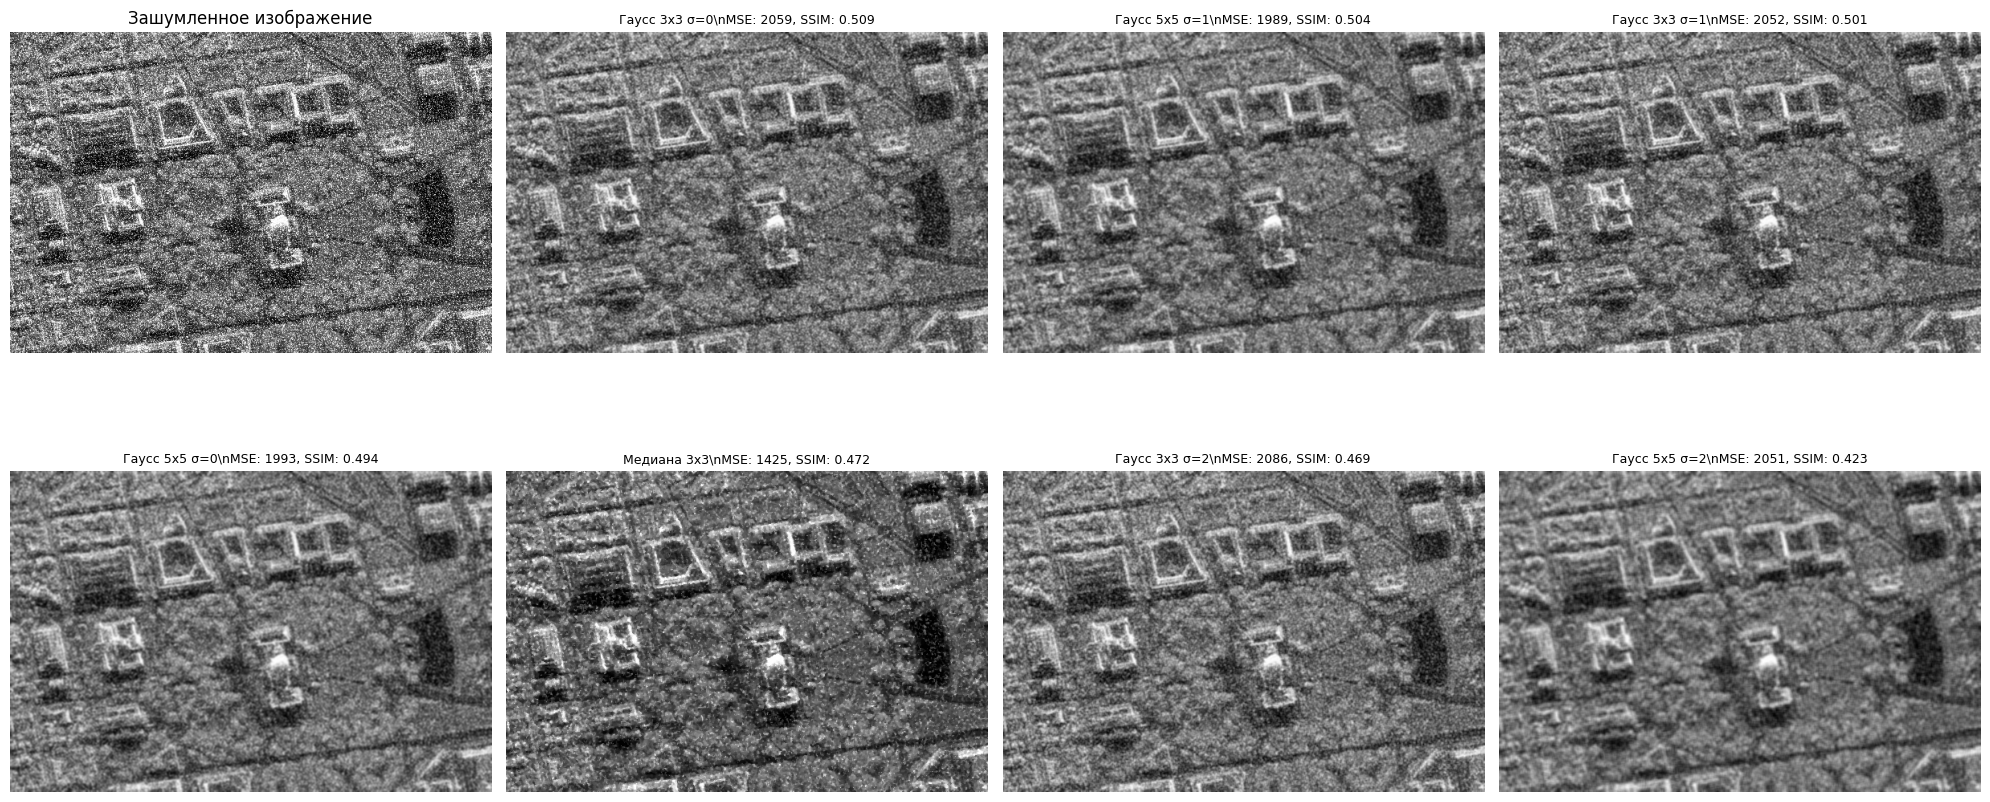

\nЛучший по MSE: Медиана 5x5
MSE: 1221.2
\nЛучший по SSIM: Гаусс 3x3 σ=0
SSIM: 0.5089


In [6]:
# Блок 6: Визуализация результатов
def show_filtered_images(noisy_img, results_dict, top_n=8):
    """Визуализация топ-N фильтров"""

    # Сортируем по SSIM (чем больше, тем лучше)
    sorted_items = sorted(
        results_dict.items(),
        key=lambda x: x[1]['ssim'],
        reverse=True
    )[:top_n]

    # Создаем график
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    # Исходное зашумленное изображение
    axes[0].imshow(noisy_img)
    axes[0].set_title('Зашумленное изображение')
    axes[0].axis('off')

    # Топ фильтров
    for idx, (name, data) in enumerate(sorted_items, 1):
        if idx < len(axes):
            axes[idx].imshow(data['image'])
            title = f"{name}\\nMSE: {data['mse']:.0f}, SSIM: {data['ssim']:.3f}"
            axes[idx].set_title(title, fontsize=9)
            axes[idx].axis('off')

    # Скрываем лишние оси
    for idx in range(len(sorted_items) + 1, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Вывод лучших фильтров
    best_mse = min(sorted_items, key=lambda x: x[1]['mse'])
    best_ssim = max(sorted_items, key=lambda x: x[1]['ssim'])

    print(f"\\nЛучший по MSE: {best_mse[0]}")
    print(f"MSE: {best_mse[1]['mse']:.1f}")

    print(f"\\nЛучший по SSIM: {best_ssim[0]}")
    print(f"SSIM: {best_ssim[1]['ssim']:.4f}")

# Показываем результаты
show_filtered_images(img_with_gaussian, gauss_results)

Тестирование фильтров на равномерном шуме:
Оценка качества фильтрации:
--------------------------------------------------
Гаусс 3x3 σ=0             MSE: 11439.7 | SSIM: 0.2155
Гаусс 5x5 σ=0             MSE: 11103.9 | SSIM: 0.2250
Гаусс 3x3 σ=1             MSE: 11362.5 | SSIM: 0.2155
Гаусс 5x5 σ=1             MSE: 11138.0 | SSIM: 0.2264
Гаусс 3x3 σ=2             MSE: 11320.7 | SSIM: 0.2050
Гаусс 5x5 σ=2             MSE: 11007.8 | SSIM: 0.2051
Медиана 3x3               MSE: 17022.3 | SSIM: 0.0872
Медиана 5x5               MSE: 17174.2 | SSIM: 0.0758
Билатеральный σ=25        MSE: 16767.7 | SSIM: 0.0959
Билатеральный σ=75        MSE: 14855.3 | SSIM: 0.1206
NLM h=10                  MSE: 16770.9 | SSIM: 0.1070
NLM h=20                  MSE: 16770.9 | SSIM: 0.1069


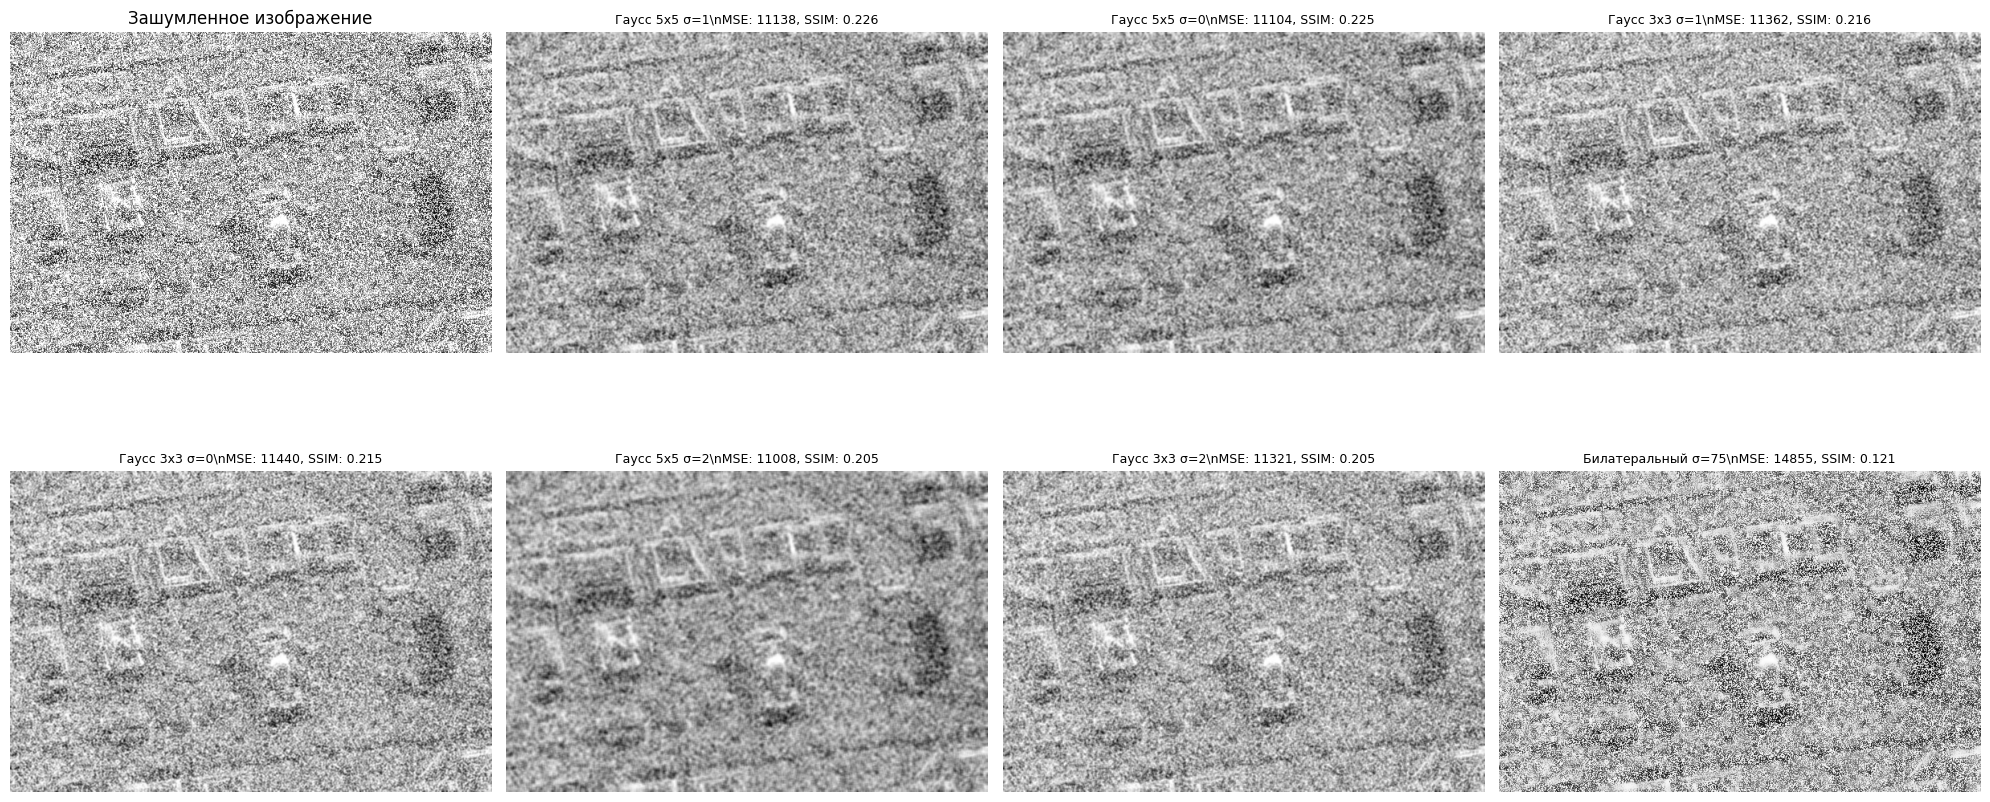

\nЛучший по MSE: Гаусс 5x5 σ=2
MSE: 11007.8
\nЛучший по SSIM: Гаусс 5x5 σ=1
SSIM: 0.2264


In [7]:
# Блок 7: Сравнение с равномерным шумом
print("Тестирование фильтров на равномерном шуме:")
print("=" * 60)
uniform_results = compare_filters(img_with_uniform, img_gray)
show_filtered_images(img_with_uniform, uniform_results)

In [8]:
# Блок 8: Сравнительный анализ
print("Сводные результаты:")
print("=" * 60)

# Создаем таблицу сравнения
print(f"{'Фильтр':25} {'Гауссовский шум':20} {'Равномерный шум':20}")
print(f"{'':25} {'MSE':>8} {'SSIM':>8} {'MSE':>8} {'SSIM':>8}")
print("-" * 70)

# Общие фильтры для сравнения
common_filters = ['Гаусс 3x3 σ=1', 'Медиана 5x5', 'Билатеральный σ=75', 'NLM h=20']

for filter_name in common_filters:
    if filter_name in gauss_results and filter_name in uniform_results:
        g_mse = gauss_results[filter_name]['mse']
        g_ssim = gauss_results[filter_name]['ssim']
        u_mse = uniform_results[filter_name]['mse']
        u_ssim = uniform_results[filter_name]['ssim']

        print(f"{filter_name:25} {g_mse:8.1f} {g_ssim:8.4f} {u_mse:8.1f} {u_ssim:8.4f}")

Сводные результаты:
Фильтр                    Гауссовский шум      Равномерный шум     
                               MSE     SSIM      MSE     SSIM
----------------------------------------------------------------------
Гаусс 3x3 σ=1               2051.7   0.5014  11362.5   0.2155
Медиана 5x5                 1221.2   0.4222  17174.2   0.0758
Билатеральный σ=75          2060.0   0.4151  14855.3   0.1206
NLM h=20                    4185.7   0.3212  16770.9   0.1069
